<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Machine Learning: Artificial Neural Networks

### [Luis Martí](http://lmarti.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
#### [`http://lmarti.com/2016-1-ml`](http://lmarti.com/2016-1-ml)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
seaborn.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext tikzmagic
%config InlineBackend.figure_format = 'retina'
import random
random.seed(a=42)

# The Multilayer Perceptron

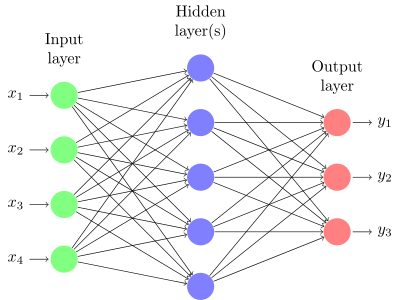

In [2]:
%tikz -s 400,300 -sc 1.2 -f svg \input{imgs/05/neural-network.tikz}

## Flashback from class: MLP with backpropagation

* We have to optimize $\boldsymbol{w}$ such that $E$ is at a **minimum**.


* Backpropagation of errors is a procedure to compute the **gradient of the error function with respect to the weights** of a neural network.


* We can use the gradient from backprop to apply **gradient descent**.


<div class="container-fluid">
  <div class="row">
      <div class="col-md-3" align='center'>
      </div>
      <div class="col-md-6">
      <div class='well well-sm'>
              <img src='imgs/05/ann-learning.svg'/>
      </div>
      </div>
      <div class="col-md-3" align='center'>
      </div>
  </div>
</div>

https://www.youtube.com/embed/MkLJ-9MubKQ


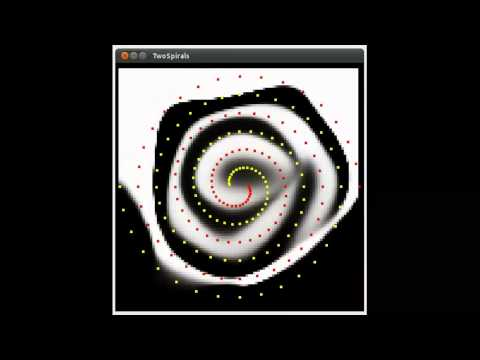

In [3]:
from IPython.display import YouTubeVideo
print(YouTubeVideo("MkLJ-9MubKQ").src)
YouTubeVideo("MkLJ-9MubKQ")

## Difficulties

* There are many **local minima**.
* The optimization problem is **ill-conditioned**.
* There are many **flat regions** (saddle points).
* There is **no guarantee** to reach the global minimum.
* Deep architectures suffer from the **vanishing gradient** problem.
* Neural networks are *usually* considered to be the **blackest box** of all learning algorithms.
* There are sooo many **hyperparameters** (number of layers/nodes, activation function, connectivity, weight initialization, loss function, regularization, ...).
* Training neural networks has been regarded as **black magic** by many researchers.
* And here is the grimoire: [Neural Networks: Tricks of the Trade](http://link.springer.com/book/10.1007%2F978-3-642-35289-8) (1st edition: 1998; 2nd edition: 2012).


However, there have been three hypes around ANNs:

* Perceptron (50s-XOR problem)
* Backpropagation (80s-SVM)
* Deep Learning (2006-now)

And they work incredibly well in practice.

## XOR Problem

In [4]:
# Dataset
X = np.array([[0, 1], [1, 0], [0, 0], [1, 1]])
Y = np.array([1, 1, 0, 0])
N = Y.shape[0]

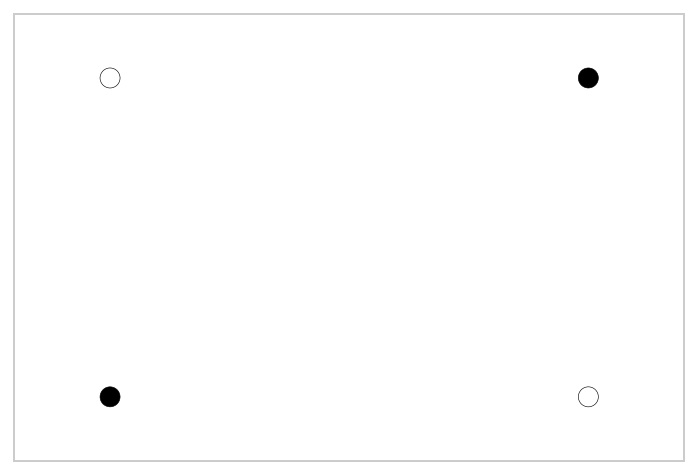

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cm.gray, s=100)
r = plt.setp(plt.gca(), xticks=(), yticks=())

## Error Surface of the XOR Problem

Activation function

In [6]:
def logit(a): return 1.0 / (1+np.exp(-a))

### A *handmade* XOR MLP
Forward propagation for 2 inputs (x1, x2), 2 hidden nodes, 1 output

In [7]:
def fprop(x1,x2,w1=0.1,w2=0.2,b1=0.1,w3=-0.2,w4=0.2,b2=-0.1,w5=-0.3,w6=-0.25,b3=0.2):
    return logit(b1+w1*logit(b2+w3*x1+w4*x2)+w2*logit(b3+w5*x1+w6*x2))

In [8]:
mpl.rcParams.update({"font.size": 15})

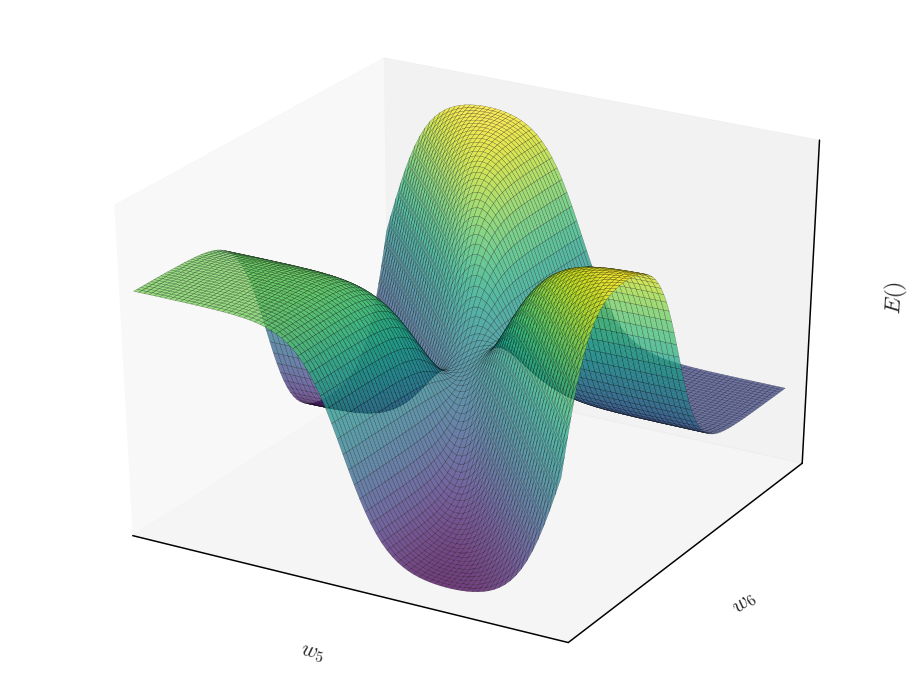

In [9]:
i, j = 4, 5 # Weight indices
fig = plt.figure(figsize=(8, 6))
W1, W2 = np.meshgrid(np.arange(-10, 10, 0.25), np.arange(-10, 10, 0.25))
E = np.sum([(fprop(X[n, 0], X[n, 1], **{"w%d"%(i+1) : W1, "w%d"%(j+1) : W2})-Y[n])**2
            for n in range(N)], axis=0)
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(W1, W2, E, rstride=1, cstride=1, cmap=cm.viridis, lw=0.11, alpha=0.74)
plt.setp(ax, xticks=(), yticks=(), zticks=(), xlabel="$w_%d$" % (i+1), ylabel="$w_%d$" % (j+1), zlabel="$E()$");

## Local Minima 

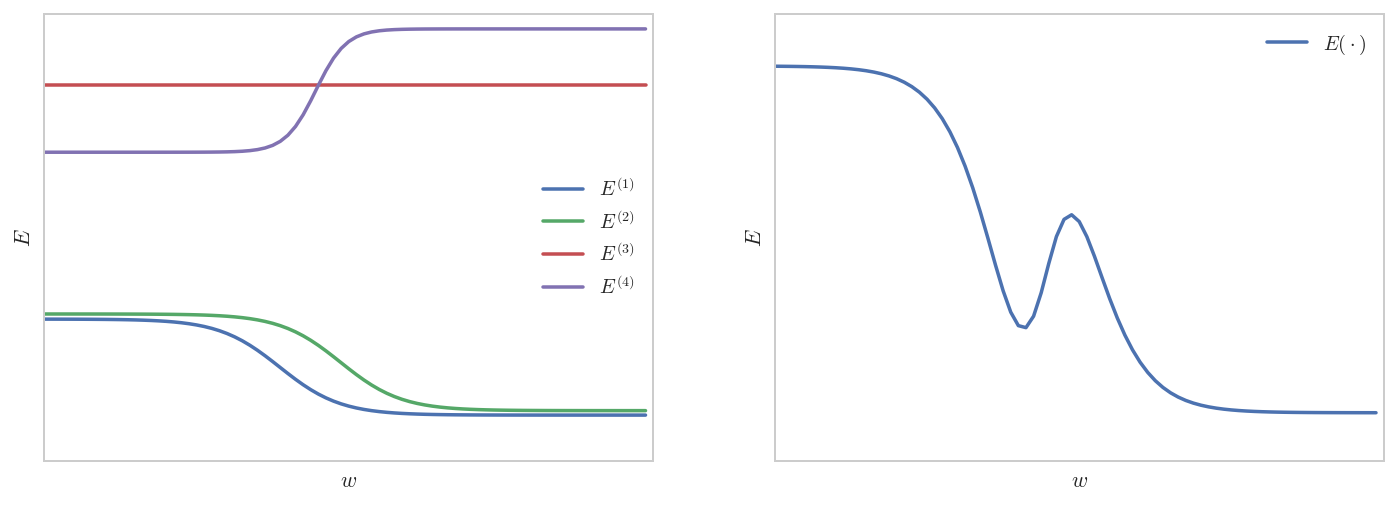

In [10]:
i, j = 4, 5
plt.figure(figsize=(12, 4))
W = np.arange(-10, 10, 0.25)
errors = [(fprop(X[n, 0], X[n, 1], **{"w%d"%(i+1) : W, "w%d"%(j+1) : W+2})-Y[n])**2
          for n in range(N)]
plt.subplot(1, 2, 1)
for n in range(N): 
    plt.plot(W, errors[n], label="$E^{(%d)}$" % (n+1))
plt.setp(plt.gca(), xticks=(), yticks=(), xlabel="$w$", ylabel="$E$");plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(W, np.sum(errors, axis=0), label="$E(\cdot)$")
plt.setp(plt.gca(), xticks=(), yticks=(), xlabel="$w$", ylabel="$E$");plt.legend(loc="best");

In [11]:
mpl.rcParams.update({"font.size": 11})

# The Original Prop/Backprop Formulae

## Propagation

In each layer $l$:

$$a^l_j = \sum_i w^l_{ji} x^l_i$$
$$y^l_j = g^l(a^l_j)$$

where

* $y^l_j$ is the $j$th output
* $x^l_i$ is the $i$th input
* $w^l_{ji}$ is the weight
* $a^l_{j}$ is called activation
* $g^l(\cdot)$ is the activation function, e.g. $\tanh$ in the hidden layers and the identity in the last layer (for regression)

## Error function (SSE)

$$E = \frac{1}{2} \sum_n \sum_j \left( y_j^{L}(\boldsymbol{x}^{(n)}) - t_j^{(n)} \right)^2$$

## Backpropagation

In each layer (we will omit the sample index $n$ and layer $l$)

$$\delta_j = \begin{cases}y_j - t_j & \text{in the output layer}\\\\ g'(a_j) \sum_k \frac{\partial E}{\partial y_k} & \text{otherwise}\end{cases},$$

$$\frac{\partial E}{\partial w_{ji}} = \delta_j x_i;\quad \frac{\partial E}{\partial x_i} = \delta_j w_{ji}$$

where

* all nodes $k$ are in the layer after $j$
* $a_j$ is known from progagation: $\sum_i w_{ji} x_i$
* actually you do not have to save $a_j$ because $g'(a_j)$ usually can be computed from $y_j$, e.g.
    * identity function: $g'(a_j) = 1$
    * $\tanh$: $g'(a_j) = 1 - y_j^2$
* $\frac{\partial E^{(n)}}{\partial w_{ji}}$ will be used to update the weight $w_{ji}$ in gradient descent
* $\frac{\partial E^{(n)}}{\partial x_i}$ will be passed to the previous layer to compute the deltas

**Do not forget to sum up the gradient with respect to the weights for each training example!**

## Efficient Implementation for Fully Connected Layers

* Make sure that you have an efficient **linear algebra library**.
* Organize your data in matrices, i.e.
    * The matrix $\boldsymbol{X}$ contains an input vector in each row. Note that you must expand each row by the bias 1.
    * The matrix $\boldsymbol{T}$ contains an output (of the network) in each row.
* Each layer should have the functions
    * `fprop(W, X, g) -> Y`
    * `backprop(W, X, g_derivative, Y, dE/dY) -> dE/dX, dEdW`

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3" align='center'>
      </div>
      <div class="col-md-6">
      <div class='well well-sm'>
              <img src='imgs/05/backprop.svg'/>
      </div>
      </div>
      <div class="col-md-3" align='center'>
      </div>
  </div>
</div>

## Efficient forward propagation

In each layer

$$\boldsymbol{A} = \boldsymbol{X} \boldsymbol{W}^T$$
$$\boldsymbol{Y} = g(\boldsymbol{A})$$

where

* $\boldsymbol{Y} \in \mathbb{R}^{N \times J}$ contains an output vector in each row, i.e. $\boldsymbol{Y}_{nj} = y^{(n)}_j$
* $\boldsymbol{X} \in \mathbb{R}^{N \times I}$ contains an input vector (the output of the previous layer) in each row, i.e. $\boldsymbol{X}_{ni} = x^{(n)}_i$
* $\boldsymbol{W} \in \mathbb{R}^{J \times I}$ is the weight matrix of the layer, i.e. $\boldsymbol{W}_{ji}$ is the weight between input $i$ and output $j$.
* $g$ is the activation function (implemented to work with matrices)
* $I$ is the number of inputs, i.e. the number of outputs of the previous layer plus 1 (for the bias)
* $J$ is the number of outputs

**Make sure that you add the bias entry in each row before you pass $Y$ as input to the next layer!**

Error function (SSE)

$$E = \frac{1}{2} ||\boldsymbol{Y} - \boldsymbol{T}||_2^2$$

where

* $||\cdot||_2$ is the [Frobenius norm](http://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm).

# Efficient Backpropagation

In each layer

$$\Delta = g'(\boldsymbol{A}) \ast \frac{\partial E}{\partial \boldsymbol{Y}}$$
$$\frac{\partial E}{\partial \boldsymbol{W}} = \Delta^T \cdot \boldsymbol{X}$$
$$\frac{\partial E}{\partial \boldsymbol{X}} = \Delta \cdot \boldsymbol{W}$$

where

* $*$ is the [Hadamard product](http://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29) or Schur product or entrywise product
* $\frac{\partial E}{\partial \boldsymbol{Y}}$ contains derivatives of the error function with respect to the outputs ($\boldsymbol{Y} - \boldsymbol{T} = \frac{\partial E}{\partial \boldsymbol{Y}}$ in the last layer)
* $\frac{\partial E}{\partial \boldsymbol{X}} \in \mathbb{R}^{N \times I}$ contains derivatives of the error function with respect to the inputs and will be passed to the previous layer
* $\Delta \in \mathbb{R}^{N \times J}$ contains deltas: $\delta_j^{(n)} = \Delta_{jn}$
* $g'$ is the derivative of $g$ and can be computed based only on $\boldsymbol{Y}$
* $\frac{\partial E}{\partial \boldsymbol{W}} \in \mathbb{R}^{J \times I}$ contains the derivatives of the error function with respect to $\boldsymbol{W}$ and will be used to optimize the weights of the ANN

**Make sure that you remove the bias entry in each row before you pass $\frac{\partial E}{\partial \boldsymbol{X}}$ to the previous layer!**

## Tips for Your Implementations

* Check your gradients.
* Check your gradients.
* Check your gradients.
* With finite differences:
$$\frac{\partial E^{(n)}}{\partial w_{ji}} = \frac{E^{(n)}(w_{ji} + \varepsilon) - E^{(n)}(w_{ji} - \varepsilon)}{2 \varepsilon} + \mathcal{O}(\varepsilon^2)$$

## Question 1

* How should we initialize the weights $\boldsymbol{w}$?

## Answer 1

* Draw components of $\boldsymbol{w}$ iid (independend and identically distributed) from a Gaussian distrubition with **small** standard deviation, e.g. 0.05.
* Initialization with 0 will prevent the gradient from flowing back to the lower layers:
$$\frac{\partial E}{\partial x_i} = \delta_j w_{ji}$$

In [12]:
np.random.randn(10) * 0.05

array([ 0.01227207,  0.04903826,  0.04878162, -0.06902814, -0.03861545,
        0.13246795, -0.00242975, -0.0279075 , -0.00878195,  0.01282136])

## Derivatives of Activation Functions

* Identity

$$y = g(a) = a$$
$$g'(a) = 1$$


* Hyperbolic tangent

$$y = g(a) = \tanh(a)$$
$$g'(a) = 1 - \tanh^2(a) = 1-y^2$$


* Logistic function

$$y = g(a) = \frac{1}{1+\exp{-a}}$$
$$g'(a) = g(a) (1 - g(a)) = y (1-y)$$

In [13]:
def plot_afun(x, y, sp_idx, label=None):
    """Plot activation function."""
    ax = plt.subplot(2, 4, sp_idx)
    if label is not None: 
        plt.title(label)
    plt.setp(ax, xlim=(np.min(x), np.max(x)), ylim=(np.min(y)-0.5, np.max(y)+0.5))
    plt.plot(x, y)

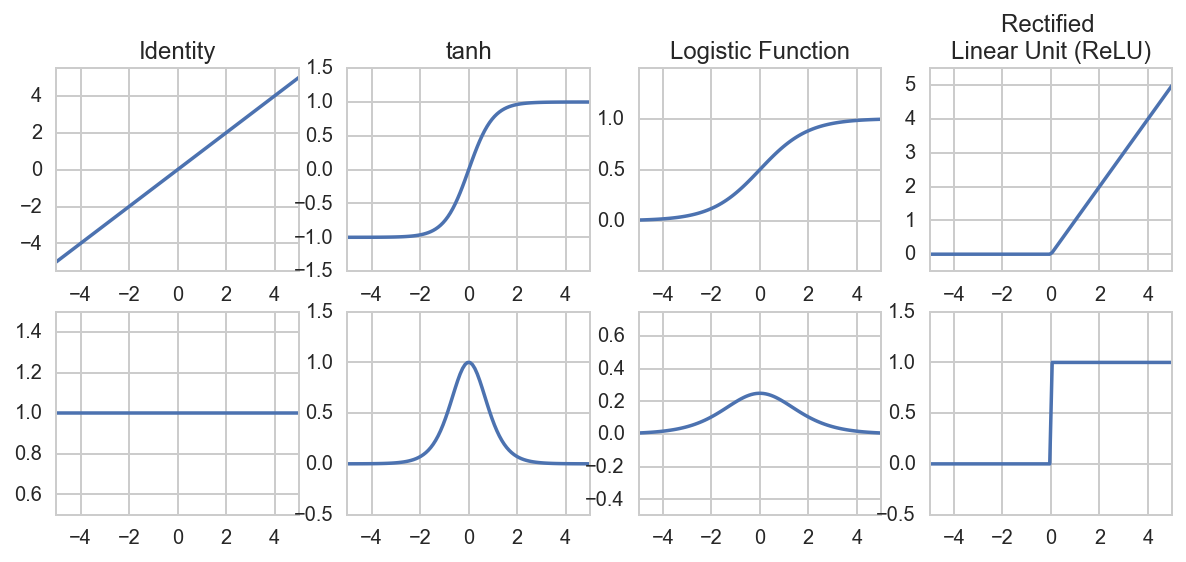

In [14]:
plt.figure(figsize=(10, 4))
x = np.linspace(-5, 5, 100)
plot_afun(x, x, 1, label="Identity")
plot_afun(x, np.tanh(x), 2, label="tanh")
plot_afun(x, logit(x), 3, label="Logistic Function")
plot_afun(x, np.max((x, np.zeros_like(x)), axis=0), 4, label="Rectified \nLinear Unit (ReLU)")
plot_afun(x, np.ones_like(x), 5)
plot_afun(x, 1-np.tanh(x)**2, 6)
plot_afun(x, logit(x)*(1-logit(x)), 7)
plot_afun(x, np.max((np.sign(x), np.zeros_like(x)), axis=0), 8)

# Why do neural nets work so well in practice?

* We don't want to find the global minimum. **Overfitting!**


* Stochastic gradient descent finds **sufficiently good** local minima.

* Neural nets learn **feature hierarchies** to represent functions *efficiently*.


## Question 2

What are advantages and drawbacks in comparison to other regression and classification algorithms?

For example:

* linear regression, logistic regression
* SVR, SVM
* decision trees
* k-nearest neighbors

### Drawbacks

* input has to be a **vector of real numbers**, e.g. text must be converted befor classification
* in general, the **optimization problem** is very difficult because it is **ill-conditioned** and **non-separable**
* objective function is **not convex**, there are many local minima and flat regions
* **black box**: in most cases it is very difficult to interpret the weights of a neural network although it is possible!
* **catastrophic forgetting**: learning one instance can change the whole network

### Advantages

* universal function approximator, **nonlinear** functions can be represented
* can learn **smooth** functions
* **features will be learned** automatically
* allows learning of **hierarchical features** which is much more efficient than just one layer of abstraction
* **multiclass classification** can be integrated with linear complexity (softmax activation function, cross-entropy error function)
* it is a **parametric** model, it does not store any training data directly

## Your task: deal with the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set)



<div class="container-fluid">
  <div class="row">
      <div class="col-md-4" align='center'>
      Iris setosa
      <img src='imgs/05/iris_setosa.jpg'/>
      </div>
      <div class='col-md-4' align='center'>
      Iris versicolor
      <img src='imgs/05/iris_versicolor.jpg'/>
      </div>
      <div class="col-md-4" align='center'>
      Iris virginica
      <img src='imgs/05/iris_virginica.jpg'/>
      </div>
  </div>
</div>

**If we want to design an algorithm to recognize iris species, what might the data be?**

* We need a 2D array of size `[n_samples x n_features]`.

    - What would the `n_samples` refer to?
    - What might the `n_features` refer to?

Remember that there must be a **fixed** number of features for each sample, and feature
number ``i`` must be a similar kind of quantity for each sample.

### Loading the Iris Data with Scikit-learn

Scikit-learn has a very straightforward set of data on these iris species.  The data consist of
the following:

- Features in the Iris dataset:

  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm

- Target classes to predict:

  1. Iris Setosa
  2. Iris Versicolour
  3. Iris Virginica

``scikit-learn`` embeds a copy of the iris CSV file along with a helper function to load it into numpy arrays:

In [15]:
from sklearn.datasets import load_iris
iris_data = load_iris()

The resulting dataset is a ``Bunch`` object: you can see what's available using
the method ``keys()``:

In [16]:
iris_data.keys()

dict_keys(['target', 'DESCR', 'data', 'target_names', 'feature_names'])

In [17]:
n_samples, n_features = iris_data.data.shape
print(n_samples)
print(n_features)
print(iris_data.data[0])

150
4
[ 5.1  3.5  1.4  0.2]


The information about the class of each sample is stored in the ``target`` attribute of the dataset:

In [18]:
print(iris_data.data.shape)
print(iris_data.target.shape)

(150, 4)
(150,)


In [19]:
print(iris_data.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


The names of the classes are stored in the last attribute, namely ``target_names``:

In [20]:
print(iris_data.target_names)

['setosa' 'versicolor' 'virginica']


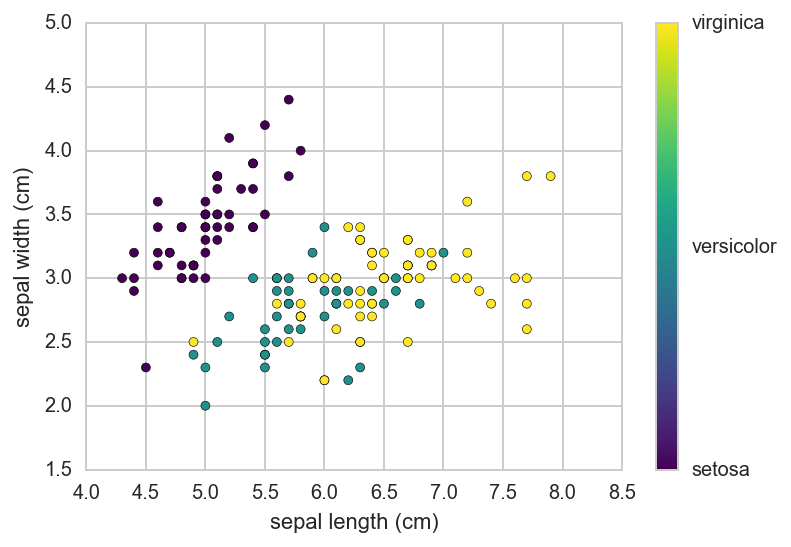

In [21]:
x_index = 0
y_index = 1
# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris_data.target_names[int(i)])

plt.scatter(iris_data.data[:, x_index], iris_data.data[:, y_index], c=iris_data.target, cmap=cm.viridis)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris_data.feature_names[x_index]);plt.ylabel(iris_data.feature_names[y_index]);

In [22]:
df = seaborn.load_dataset("iris")

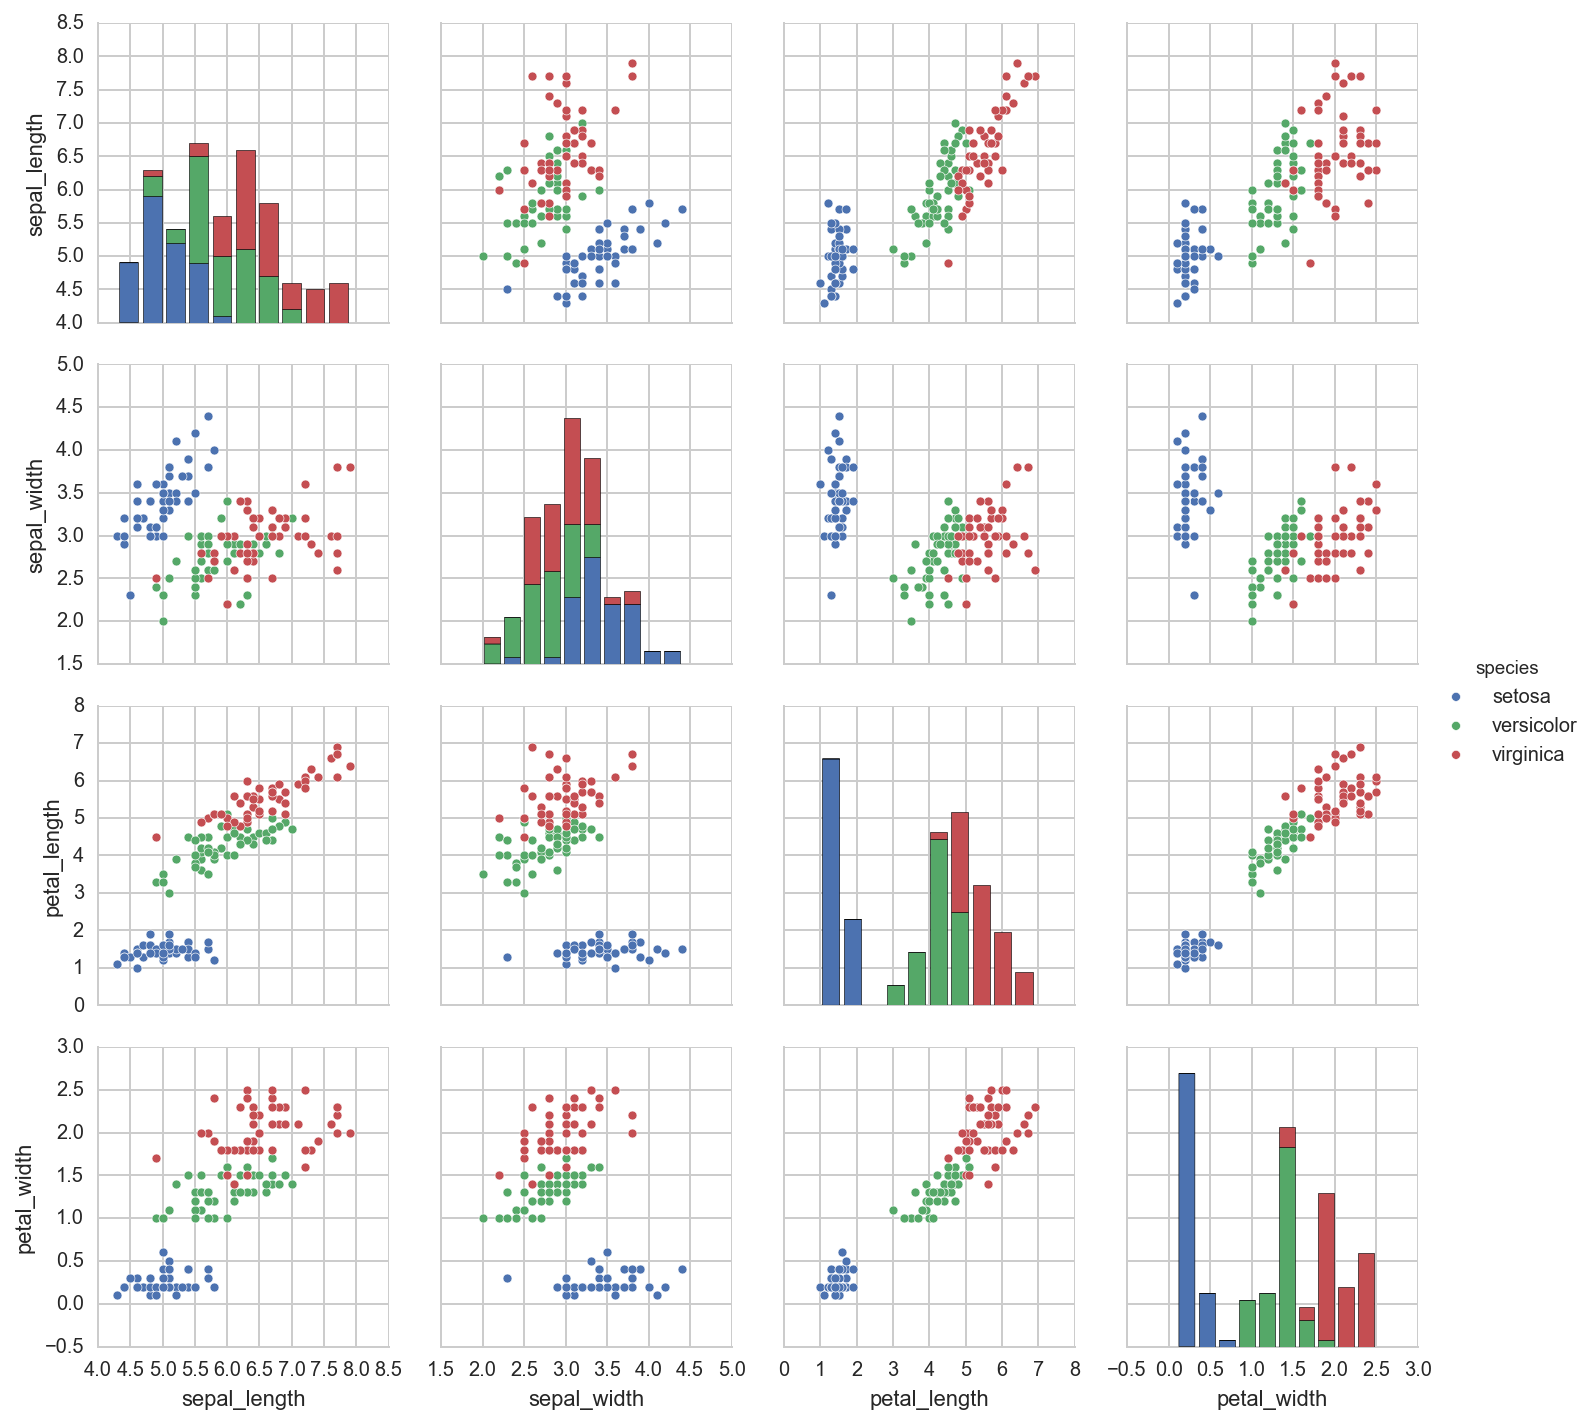

In [23]:
seaborn.pairplot(df, hue="species");

## All set... 
* you have the data!
* you must now program an MLP that learns **recognize** the flowers in the iris dataset. 
* What kind of problem is this?
* Must we transform the data?

In [24]:
class MultilayerPerceptron():
    def __init__(self):
        pass
    
    def propagate(X):
        pass
    
    def learn(X,y):
        pass

<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>

In [25]:
%load_ext version_information
%version_information scipy, numpy, matplotlib, sklearn

Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.2.0
OS Darwin 15.4.0 x86_64 i386 64bit
scipy 0.17.1
numpy 1.10.4
matplotlib 1.5.1
sklearn 0.17.1
Wed May 18 11:08:15 2016 BRT

In [26]:
# this code is here only for cosmetic reasons
from IPython.core.display import HTML
def css_styling():
    return HTML(open('custom/custom.include', 'r').read())
css_styling()